<a href="https://colab.research.google.com/github/aindrila61/ML/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Upload your Kaggle .json file

In [ ]:
#first upload the kaggle.json from pc to files then run this shell
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing twitter sentiment dataset

In [ ]:
#API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.15GB/s]


Extracting the compressed data from the file sentiment140.zip

In [ ]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'
with ZipFile(dataset,'r') as zip_ref:
  zip_ref.extractall()
  print('The dataset is extracted')

The dataset is extracted


Importing the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import re        #re->regular expression used for pattern matching,search through the data
from nltk.corpus import stopwords   #natural language toolkit
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer #convert text data to numerical data for the model
from sklearn.model_selection import train_test_split  #split original data to training data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#printing the stopwords
print(stopwords.words('english'))   #we will remove the stopwords as it is not reqd as the data is huge we only want imp things

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

Data Processing

In [ ]:
#loading the data from csv file to pandas dataframe, as pandas is used for data preprocessing
twitter_data= pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')  #read csv file and load the content to pandas dataframe

In [ ]:
#checking the number of rows and columns
twitter_data.shape

(1599999, 6)

In [ ]:
#printing the first 5 rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
from tkinter.font import names
#naming the column and reading the dataset again
column_names=['target','id','data','flag','user','text']
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=column_names,encoding='ISO-8859-1')

In [ ]:
twitter_data.shape

(1600000, 6)

In [ ]:
twitter_data.head()

,target,id,data,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#counting the number of missing values in the dataset
twitter_data.isnull().sum()  #tells how many miising values are there in each column

,0
target,0
id,0
data,0
flag,0
user,0
text,0


In [ ]:
#checking the distribution of target column
twitter_data['target'].value_counts()      #here the data is evenly distributed if it is not then we have to do upsampling or downsampling to make it equal

,count
target,
0,800000
4,800000


convert 4 to 1 in target

In [ ]:
twitter_data.replace({'target' : {4:1}}, inplace=True) #inplace is used to store the updated data in the dataframe

In [ ]:
#checking the distribution of target column
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


Stemming

Stemming is the process of reducing a word to its Root word

example: actor, actress, acting = act

In [ ]:
port_stem=PorterStemmer()

In [ ]:
def stemming(content):
  stemmed_content = re. sub('[^a-zA-Z]', ' ', content)  #only passing the text column which is the content and remove all the things which are not alphabet
  stemmed_content = stemmed_content. lower()  #uppercase to lowercase
  stemmed_content = stemmed_content. split()  #put that in a list
  stemmed_content = [port_stem. stem(word) for word in stemmed_content if not word in stopwords.words('english')]   #remove the stopwords, stem func will reduce the other words to its key words
  stemmed_content = ' '. join(stemmed_content)
  return stemmed_content

In [ ]:
twitter_data['stemmed_content' ] = twitter_data['text' ].apply(stemming)

In [ ]:
twitter_data.head()

,target,id,data,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
print(twitter_data['stemmed_content' ])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [ ]:
print(twitter_data['target' ])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [ ]:
#sepatating the data and labels
x=twitter_data['stemmed_content' ].values
y=twitter_data['target' ].values

In [ ]:
print(x)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [ ]:
print(y)

[0 0 0 ... 1 1 1]


Splitting the data to training data and test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split (x, y, test_size=0.2, stratify=y, random_state=2)  #creating 4 arrays

X_train->all training data tweets

Y_train->stores corresponding labels (y)

X_test-> test data tweets

Y_test->=1/0

test_size ->20% data will go to test data, 80% will go to training data

stratify->distributes equal no of 0 and 1 in both test and train, ie equal proportion

if the random state for 2 persons is 2, means the data will be spitted in the same way for them

In [ ]:
print(x.shape, X_train.shape,X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [ ]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [ ]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()   #like it will count how many happy words are there and then asign specific no to it

X_train = vectorizer. fit_transform(X_train)  #all the training data wil be taken & vectorizer will give score to individual words and also fitting the data
X_test = vectorizer. transform(X_test) #transforming the data based on the training data

In [ ]:
print(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9453092 stored elements and shape (1280000, 461488)>
  Coords	Values
  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (12

In [ ]:
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2289192 stored elements and shape (320000, 461488)>
  Coords	Values
  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538


0 means tweets for the first tweets and like that

Training the ML model

Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000) #max no of times the model has to go through the data

In [ ]:
model.fit(X_train,Y_train)   #model will learn from the data with the help of fit, the model will try to understand what are the words in +ve and -ve tweets

LogisticRegression(max_iter=1000)

Model Evaluation

Accuracy score

In [ ]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train) #predict the value as 1 or 0
training_data_accuracy = accuracy_score(Y_train, X_train_prediction) #extends the X_train prediction with the true labels ie Y_train
#comaparing true values with the values predicted by the model

In [ ]:
print("Accuracy score on the training data:",training_data_accuracy)

Accuracy score on the training data: 0.79871953125


In [ ]:
X_test_prediction = model.predict(X_test)
testing_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [ ]:
print("Accuracy score on the testing data:",testing_data_accuracy)

Accuracy score on the testing data: 0.77668125


both the accuracy are close to each other that means the model has performed well otherwise if one is 79% and other one is 50% or 40% like that then it would have been overfitting

Saving the trained model

In [ ]:
import pickle

In [ ]:
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb')) #create a new file and write the model in that

Using the saved model for future prediction

In [ ]:
# loading the saved model
loaded_model = pickle. load(open('/content/trained_model.sav', 'rb' ) )

In [ ]:
X_new = X_test [200]   #X_test data is the data which the model hasnot seen before & taking 200th index from the 320000 data
print(Y_test[200])      #coresponding labels of X_test is stored in Y_test
prediction = loaded_model. predict(X_new)
print(prediction)
if (prediction[0] == 0):
  print('Negative Tweet' )
else:
  print('Positive Tweet')
#checking if the predicted data is matching with the Y_test

1
[1]
Positive Tweet


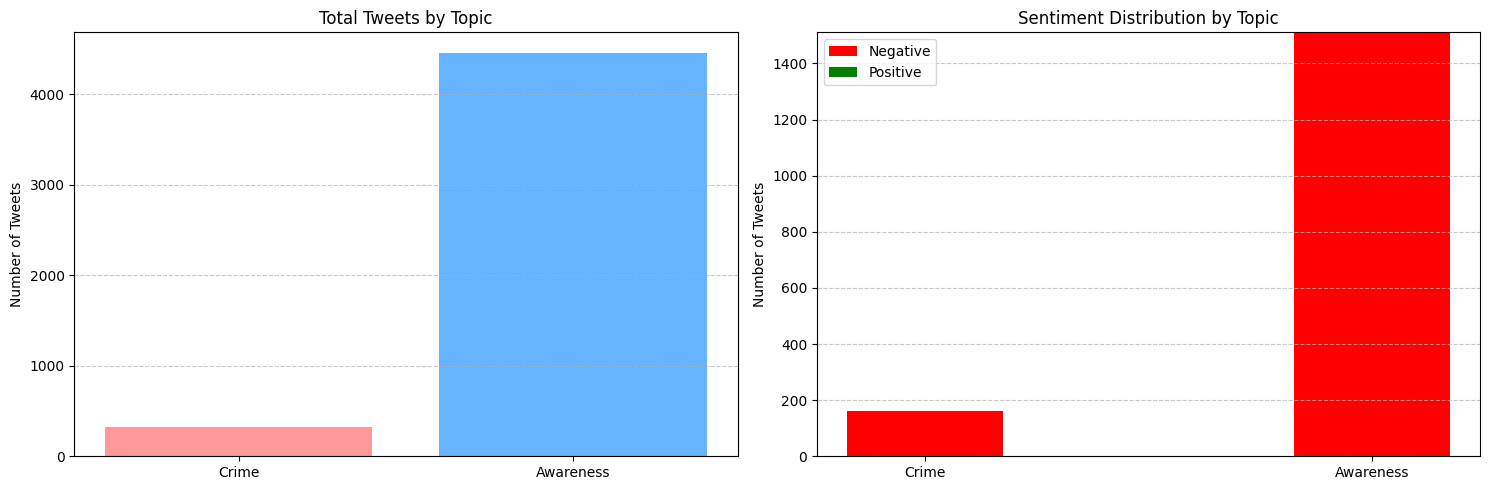

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Filter tweets containing keywords
mask_crime = twitter_data['stemmed_content'].str.contains('crime')
mask_awareness = twitter_data['stemmed_content'].str.contains('awar')  # 'awar' comes from PorterStemmer

# 2. Get counts
crime_count = mask_crime.sum()
awareness_count = mask_awareness.sum()

# 3. Get sentiment distribution
crime_negative = twitter_data.loc[mask_crime & (twitter_data['target'] == 0)].shape[0]
crime_positive = twitter_data.loc[mask_crime & (twitter_data['target'] == 4)].shape[0]

awareness_negative = twitter_data.loc[mask_awareness & (twitter_data['target'] == 0)].shape[0]
awareness_positive = twitter_data.loc[mask_awareness & (twitter_data['target'] == 4)].shape[0]

# 4. Create bar graphs
plt.figure(figsize=(15, 5))

# Graph 1: Total tweets by topic
plt.subplot(1, 2, 1)
plt.bar(['Crime', 'Awareness'], [crime_count, awareness_count], color=['#ff9999', '#66b3ff'])
plt.title('Total Tweets by Topic')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Graph 2: Sentiment breakdown
plt.subplot(1, 2, 2)
bar_width = 0.35
index = np.arange(2)

plt.bar(index, [crime_negative, awareness_negative], bar_width,
        color='red', label='Negative')
plt.bar(index, [crime_positive, awareness_positive], bar_width,
        bottom=[crime_negative, awareness_negative],
        color='green', label='Positive')

plt.title('Sentiment Distribution by Topic')
plt.ylabel('Number of Tweets')
plt.xticks(index, ['Crime', 'Awareness'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Crime tweets total: 326
Awareness tweets total: 4458

Sentiment counts:
Crime - Negative: 163, Positive: 0
Awareness - Negative: 1511, Positive: 0


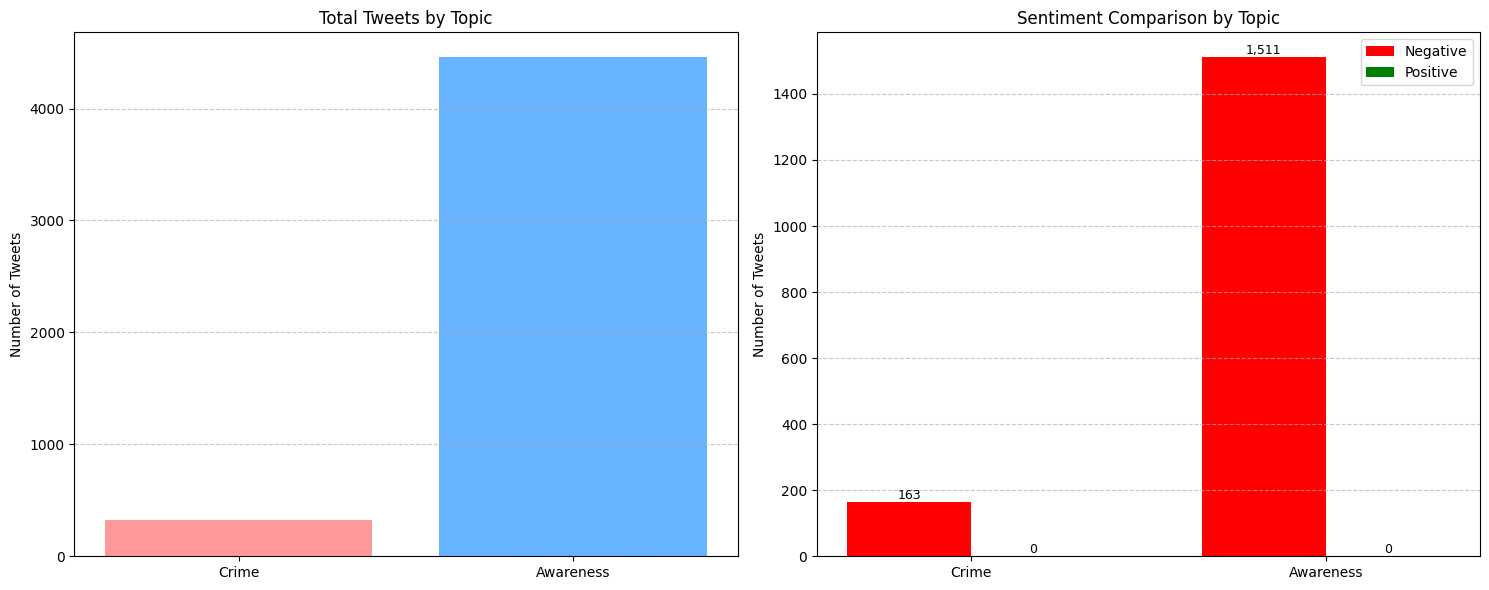

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Filter tweets containing keywords
mask_crime = twitter_data['stemmed_content'].str.contains('crime')
mask_awareness = twitter_data['stemmed_content'].str.contains('awar')  # 'awar' from stemmer

# 2. Print counts for debugging
print(f"Crime tweets total: {mask_crime.sum()}")
print(f"Awareness tweets total: {mask_awareness.sum()}")

# 3. Get sentiment distribution
crime_negative = twitter_data.loc[mask_crime & (twitter_data['target'] == 0)].shape[0]
crime_positive = twitter_data.loc[mask_crime & (twitter_data['target'] == 4)].shape[0]

awareness_negative = twitter_data.loc[mask_awareness & (twitter_data['target'] == 0)].shape[0]
awareness_positive = twitter_data.loc[mask_awareness & (twitter_data['target'] == 4)].shape[0]

print("\nSentiment counts:")
print(f"Crime - Negative: {crime_negative}, Positive: {crime_positive}")
print(f"Awareness - Negative: {awareness_negative}, Positive: {awareness_positive}")

# 4. Create fixed bar graphs (using side-by-side bars instead of stacked)
plt.figure(figsize=(15, 6))

# Graph 1: Total tweets by topic (unchanged)
plt.subplot(1, 2, 1)
plt.bar(['Crime', 'Awareness'], [mask_crime.sum(), mask_awareness.sum()],
        color=['#ff9999', '#66b3ff'])
plt.title('Total Tweets by Topic')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Graph 2: Side-by-side sentiment comparison
plt.subplot(1, 2, 2)
bar_width = 0.35
index = np.arange(2)

# Position for negative sentiment bars
neg_bars = plt.bar(index - bar_width/2, [crime_negative, awareness_negative], bar_width,
                   color='red', label='Negative')

# Position for positive sentiment bars
pos_bars = plt.bar(index + bar_width/2, [crime_positive, awareness_positive], bar_width,
                   color='green', label='Positive')

plt.title('Sentiment Comparison by Topic')
plt.ylabel('Number of Tweets')
plt.xticks(index, ['Crime', 'Awareness'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact count labels
for bars in [neg_bars, pos_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

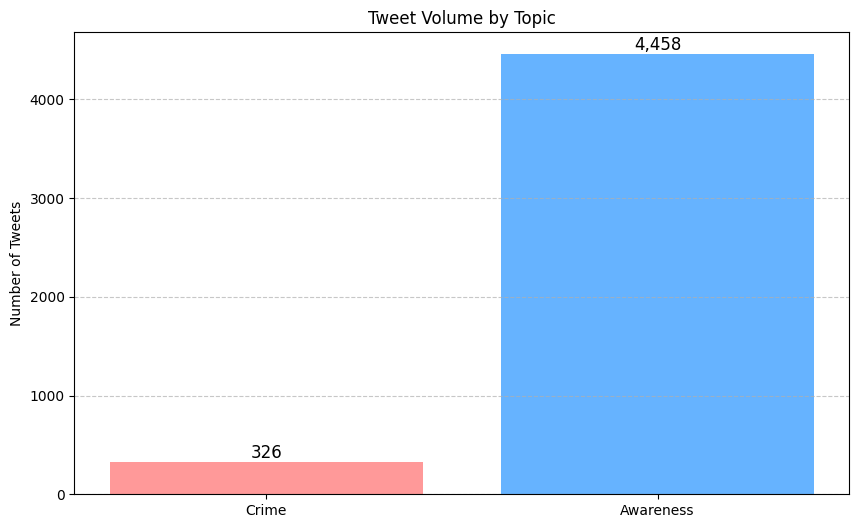


Sample Crime Tweets:
["Dear Crimestoppers, thankyou for your regular service of our burglar alarm, I'm most grateful for the new 200dB ear-deafening entry tones "
 "I'm officially a witness to a hate crime. Oh did I mention the dying giant raven on my doorstep eight hours after the crime occurred? "
 'It should be a crime to make kids get up thusbearly to go to school ']

Sample Awareness Tweets:
["I'm over it, but accutely aware that only Bob will ever know that "
 "@itspink WHAT?BOYZONE ARE REFORMING???I'm never aware of anything "
 'just watched digital spy awards, diana vickers could have won one ']


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Filter tweets by keyword presence
crime_tweets = twitter_data[twitter_data['stemmed_content'].str.contains('crime')]
awareness_tweets = twitter_data[twitter_data['stemmed_content'].str.contains('awar')]  # Stemmed version

# 2. Get counts
crime_count = len(crime_tweets)
awareness_count = len(awareness_tweets)

# 3. Create bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(['Crime', 'Awareness'], [crime_count, awareness_count],
               color=['#ff9999', '#66b3ff'])

plt.title('Tweet Volume by Topic')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add exact counts on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,}', ha='center', va='bottom', fontsize=12)

plt.show()

# 4. Print sample tweets for context
print("\nSample Crime Tweets:")
print(crime_tweets['text'].head(3).values)
print("\nSample Awareness Tweets:")
print(awareness_tweets['text'].head(3).values)

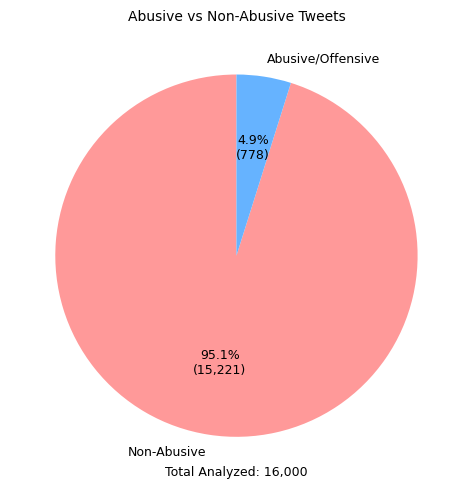


Sample Abusive Tweets:
- School email won't open  and I have geography stuff on there...
- @foprof LOL.  Leave a kid on internet and the kid will do st...
- @CatholicChicks hate bein on the phone that long 


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define offensive words list
offensive_words = [
    'abus', 'ass', 'asshol', 'bastard', 'bitch', 'bullshit', 'cock', 'crap', 'cunt',
    'damn', 'dick', 'fag', 'fuck', 'hell', 'hate', 'idiot', 'moron', 'nigga', 'nigger',
    'piss', 'pussy', 'shit', 'slut', 'stupid', 'whore', 'rape', 'kill', 'murder', 'terrorist'
]

# Classify tweets
def classify_tweet(tweet):
    words = tweet.split()
    return 'Abusive/Offensive' if any(word in offensive_words for word in words) else 'Non-Abusive'

# Sample data
sample_data = twitter_data.sample(frac=0.01, random_state=42)
sample_data['classification'] = sample_data['stemmed_content'].apply(classify_tweet)
class_counts = sample_data['classification'].value_counts()

# Create compact pie chart
plt.figure(figsize=(6, 5))  # Smaller figure size

# Pie chart with tighter layout
plt.pie(class_counts,
        labels=class_counts.index,
        colors=['#ff9999', '#66b3ff'],
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*sum(class_counts)):,})',  # Include counts in label
        startangle=90,
        textprops={'fontsize': 9})  # Smaller font

plt.title('Abusive vs Non-Abusive Tweets', fontsize=10)
plt.tight_layout(pad=1.0)  # Tighter spacing

# Add summary box
summary_text = (f"Total Analyzed: {len(sample_data):,}\n")
plt.gcf().text(0.5, 0.01, summary_text, ha='center', fontsize=9)

plt.show()

# Print compact sample
print("\nSample Abusive Tweets:")
for tweet in sample_data[sample_data['classification'] == 'Abusive/Offensive']['text'].head(3).values:
    print(f"- {tweet[:60]}{'...' if len(tweet) > 60 else ''}")

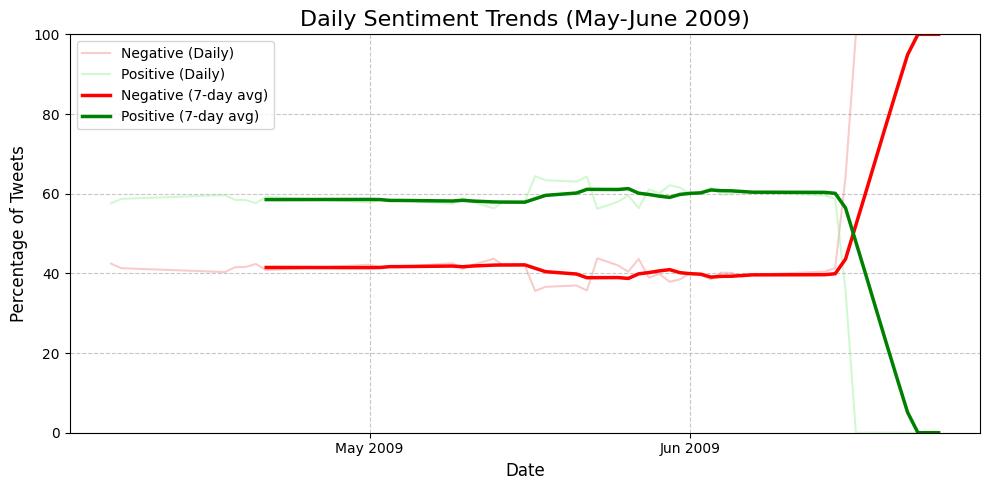

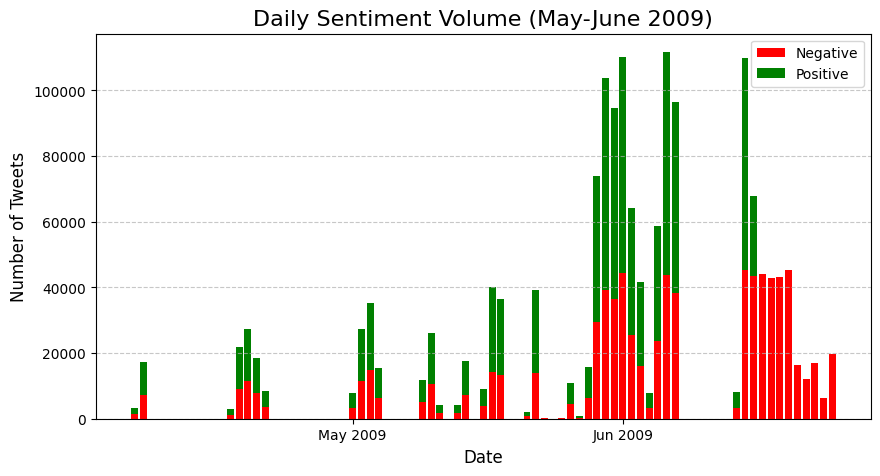

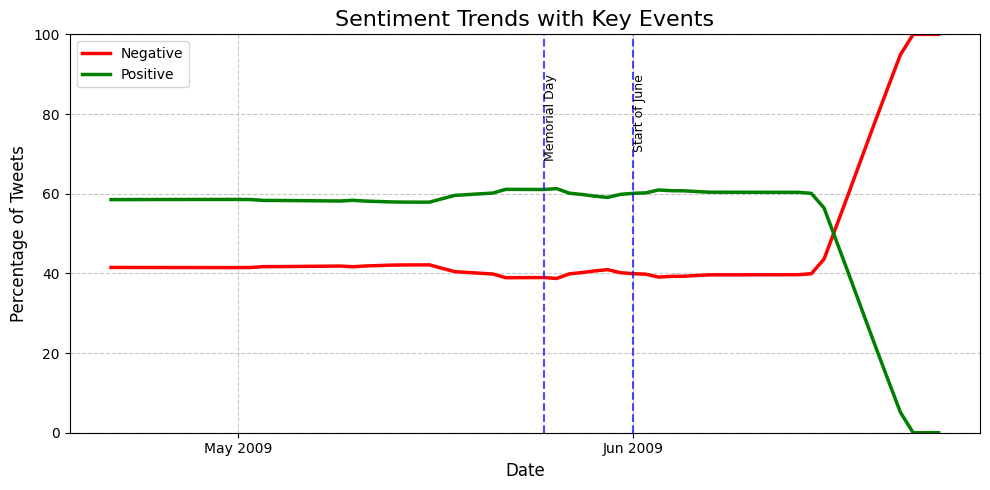

<Figure size 1200x600 with 0 Axes>

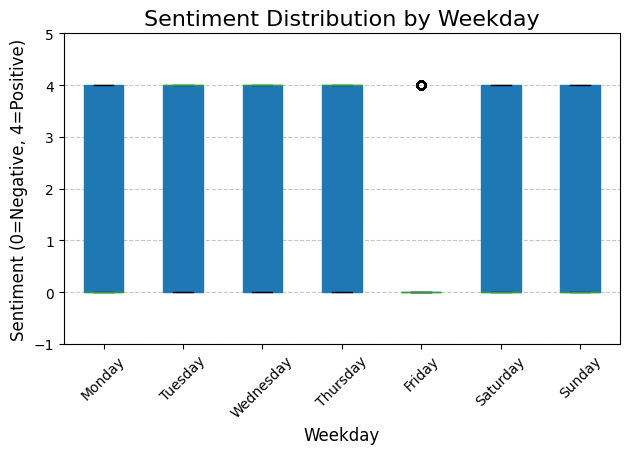

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter, MonthLocator

# Reload data with proper column names
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                           encoding='ISO-8859-1', header=None, names=column_names)

# Convert date strings to datetime objects
twitter_data['date'] = pd.to_datetime(twitter_data['date'],
                                     format='%a %b %d %H:%M:%S PDT %Y',
                                     errors='coerce')

# Filter out invalid dates
twitter_data = twitter_data.dropna(subset=['date'])

# Create daily aggregates for better trend visualization
daily_sentiment = twitter_data.groupby([pd.Grouper(key='date', freq='D'), 'target']).size().unstack(fill_value=0)
daily_sentiment = daily_sentiment.rename(columns={0: 'Negative', 4: 'Positive'})

# Add missing columns if needed
if 'Negative' not in daily_sentiment.columns:
    daily_sentiment['Negative'] = 0
if 'Positive' not in daily_sentiment.columns:
    daily_sentiment['Positive'] = 0

# Calculate daily percentages
daily_sentiment['Total'] = daily_sentiment['Negative'] + daily_sentiment['Positive']
daily_sentiment['Negative %'] = daily_sentiment['Negative'] / daily_sentiment['Total'] * 100
daily_sentiment['Positive %'] = daily_sentiment['Positive'] / daily_sentiment['Total'] * 100

# Create a 7-day rolling average for smoother trends
daily_sentiment['Negative % (7-day avg)'] = daily_sentiment['Negative %'].rolling(window=7).mean()
daily_sentiment['Positive % (7-day avg)'] = daily_sentiment['Positive %'].rolling(window=7).mean()

# 1. LINE GRAPH - Daily Sentiment Trends
plt.figure(figsize=(10, 5))

# Plot raw data as faint background
plt.plot(daily_sentiment.index, daily_sentiment['Negative %'],
         color='lightcoral', alpha=0.4, label='Negative (Daily)')
plt.plot(daily_sentiment.index, daily_sentiment['Positive %'],
         color='lightgreen', alpha=0.4, label='Positive (Daily)')

# Plot smoothed trends
plt.plot(daily_sentiment.index, daily_sentiment['Negative % (7-day avg)'],
         marker='', color='red', linewidth=2.5, label='Negative (7-day avg)')
plt.plot(daily_sentiment.index, daily_sentiment['Positive % (7-day avg)'],
         marker='', color='green', linewidth=2.5, label='Positive (7-day avg)')

plt.title('Daily Sentiment Trends (May-June 2009)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage of Tweets', fontsize=12)
plt.ylim(0, 100)

# Format x-axis for dates
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

# 2. BAR GRAPH - Daily Sentiment Volume
plt.figure(figsize=(10, 5))

# Create stacked bar chart
plt.bar(daily_sentiment.index, daily_sentiment['Negative'],
        color='red', label='Negative')
plt.bar(daily_sentiment.index, daily_sentiment['Positive'],
        bottom=daily_sentiment['Negative'],
        color='green', label='Positive')

plt.title('Daily Sentiment Volume (May-June 2009)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Format x-axis for dates
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)

# Add important events (customize these dates based on your dataset)
important_dates = {
    '2009-06-01': 'Start of June',
    '2009-05-25': 'Memorial Day',
    '2009-06-12': 'Iran Election'
}

# Add event markers to line graph
plt.figure(figsize=(10, 5))
plt.plot(daily_sentiment.index, daily_sentiment['Negative % (7-day avg)'],
         color='red', linewidth=2.5, label='Negative')
plt.plot(daily_sentiment.index, daily_sentiment['Positive % (7-day avg)'],
         color='green', linewidth=2.5, label='Positive')

# Add event markers
for date_str, label in important_dates.items():
    date = pd.to_datetime(date_str)
    if date in daily_sentiment.index:
        plt.axvline(x=date, color='blue', linestyle='--', alpha=0.7)
        plt.text(date, 90, label, rotation=90, va='top', fontsize=9)

plt.title('Sentiment Trends with Key Events', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage of Tweets', fontsize=12)
plt.ylim(0, 100)
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

# 3. WEEKDAY ANALYSIS - Box plot
twitter_data['weekday'] = twitter_data['date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
twitter_data.boxplot(column='target', by='weekday', grid=False,
                     positions=range(len(weekday_order)),
                     patch_artist=True)
plt.title('Sentiment Distribution by Weekday', fontsize=16)
plt.suptitle('')  # Remove auto title
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Sentiment (0=Negative, 4=Positive)', fontsize=12)
plt.xticks(range(len(weekday_order)), weekday_order, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(-1, 5)
plt.tight_layout()
plt.show()